# Transfer learning compared to meta learning 

Meta learning prepares a model to interpolate generally over a submanifold in the parameter space, 
but the submanifold dimension is practically small relative the parameter space dimension, 
because each one must be engineered. 
Alternatively, transfer learning effectively contributes significant samples sizes to some dimensions 
and usually arrives with a little bias. 
Here, we show (HYPOTHESIZE) that meta learning is competitive near its submanifold, 
but sufficiently-abstracted transfer learning ultimately produces greater generality beyond the submanifold, 
at least when bias is sufficiently low. 
Ultimately, it's a trade-off between meta learning's effective submanifold, 
and the relevance of a data abstraction produced by transfer learning. 
If the abstraction is coherent and small, it should be more general. 
When done correctly, packing greater volumes of data into smaller dimensional spaces lends to greater generality.

## Succinct abstractions 

The value of transfer learning is that it doesn't focus on an infeasibly small subspace of $\Theta$. 
Instead, when done correctly, it's an abstraction. 
Good abstractions remove unnecessary information, but retain relevant information. 
Naively, a (near) losses autoencoder meets this requirement, 
but clearly retains information which may be irrelevant in, say, a reinforcement learning context. 
Instead, we seek to remove irrelevant information according to a particular perspective. 
For example, sufficient statistic $T(x)$ satisfies a completely lossless representation $f_X(x;\theta) = h(x)g(T(x); \theta)$. 
If $\dim(T(X)) < \dim(X)$, we can clearly see sufficient statistics are perfect abstrations.
This won't work in the era of big data, so we'll instead construct an approximate definition. 

For dimension $p$, $T(x)$ is a succinct abstraction if
 $\exists h_p, g_p \text{ such that } \mathbb{E}_{F_X} \log \frac{f(X; \theta_0)}{h_p(X)g_p(T(X); \theta_0)} \to 0$ 
 as $\dim(T(X)) = p \to \dim(X)$, where $\partial F_X / \partial x = f_X$. 

 Notice that 
 - The limiting point is sufficient statistic.
 - Faster-converging abstractions are more succinct.


 The value of succinct abstractions is dimensional reduction without meaningful loss of information. 
 In turn, dimensional reduction of data decreases the sample size necessary to fit an effective model. 

In [181]:
import torch
import torch.nn as nn 
from torchvision import datasets
from torch.nn.functional import one_hot 
from torchvision.transforms.functional import pil_to_tensor 
import random 

MNIST_DIM = 28 
LEARNING_RATE = 1e-3 
EMBEDDING_DIM = 20 
BATCH_SIZE = 100 
FIT_ITERS = 10 
EVAL_SIZE = 100 

TRAIN_DATA = datasets.MNIST('../../data', train=True, download=True) 
TEST_DATA = datasets.MNIST('../../data', train=False) 

def sample(n, train=True, download=True, train_data=None, sub_sample=False): 
    dat = TRAIN_DATA 
    if train_data is not None: 
        dat = train_data 
    if not train: 
        dat = TEST_DATA  
        pass 
    idx_list = random.choices(range(0, len(dat)), k=n) 
    if sub_sample: 
        out = [] 
        for idx in idx_list: 
            image, label = dat[idx] 
            out.append((image, label)) 
            pass 
        return out  
    x_list = [] 
    y_list = [] 
    for idx in idx_list: 
        image, label = dat[idx] 
        image = pil_to_tensor(image) 
        image = image*2/255. - .5 
        image = image.reshape([1, -1]) 
        x_list.append(image) 
        y_list.append(label) ## type(label) == int 
        pass 
    x = torch.cat(x_list) 
    y = one_hot(torch.tensor(y_list), num_classes=10).type(torch.float32) 
    return x, y 

class BaseLayer(nn.Module): 
    def __init__(self, 
            abstraction_dimension=20): 
        super().__init__() 
        self.abstraction_dimension = abstraction_dimension 
        self.fc1 = nn.Linear(MNIST_DIM*MNIST_DIM, self.abstraction_dimension) 
        self.relu1 = nn.LeakyReLU() 
        self.fc2 = nn.Linear(self.abstraction_dimension, EMBEDDING_DIM) 
        ## memory 
        self.hessian_approximation = None 
        self.hessian_center = None 
        pass 
    def forward(self, 
            x): 
        x = self.fc1(x) 
        x = self.relu1(x) 
        x = self.fc2(x) 
        return x 
    def memorize_grad(self, size=1.): 
        grad = [param.grad.detach().reshape([-1]) for param in self.parameters()] 
        grad = torch.cat(grad).reshape([-1, 1])  
        hessian_approx = grad * grad 
        if self.hessian_approximation is None: 
            self.hessian_approximation = hessian_approx 
        else: 
            self.hessian_approximation += hessian_approx ## TODO scale by sample size !! 
            pass 
        self.hessian_center = nn.utils.parameters_to_vector(self.parameters()).detach() 
        pass 
    pass 

class AutoEncoder(nn.Module): 
    def __init__(self,
            abstraction_dimension=20): 
        super().__init__() 
        self.abstraction_dimension = abstraction_dimension 
        self.base_layer = BaseLayer(abstraction_dimension=self.abstraction_dimension) 
        self.relu1 = nn.LeakyReLU()
        self.fc1 = nn.Linear(EMBEDDING_DIM, self.abstraction_dimension) 
        self.relu2 = nn.LeakyReLU() 
        self.fc2 = nn.Linear(self.abstraction_dimension, MNIST_DIM*MNIST_DIM) 
        self.optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE) 
        self.loss = nn.SmoothL1Loss() 
        pass 
    def forward(self,
            x):
        x = self.base_layer(x) 
        x = self.relu1(x) 
        x = self.fc1(x) 
        x = self.relu2(x) 
        x = self.fc2(x) 
        x = torch.sigmoid(x) 
        return x 
    def fit(self, 
            iters=FIT_ITERS, 
            batch_size=BATCH_SIZE, 
            eval_size=EVAL_SIZE, 
            train_data=None, 
            memorize=False): 
        ## fit 
        self.train() 
        for _ in range(iters): 
            self.optimizer.zero_grad() 
            x, _ = sample(n=batch_size, train=True, train_data=train_data) 
            x_hat = self(x) 
            loss = self.loss(x, x_hat) 
            loss.backward() 
            if memorize: 
                self.base_layer.memorize_grad(size=x.shape[0]) 
                pass 
            self.optimizer.step() 
            pass 
        pass 
        ## eval 
        self.eval() 
        x, _ = sample(n=eval_size, train=False) 
        x_hat = self(x) 
        err = (x - x_hat).abs().mean(dim=1).mean(dim=0) 
        return float(err) 
    pass 

class Classifier(nn.Module): 
    def __init__(self, 
            abstraction_dimension=20, 
            base_layer_transfer=None, 
            n_labels=10): 
        super().__init__() 
        self.abstraction_dimension = abstraction_dimension 
        self.n_labels=10 
        self.base_layer = BaseLayer(abstraction_dimension=self.abstraction_dimension) 
        self.relu1 = nn.LeakyReLU() 
        self.fc1 = nn.Linear(EMBEDDING_DIM, self.n_labels) 
        self.softmax = nn.Softmax(dim=1) 
        if base_layer_transfer is not None: 
            self.base_layer.load_state_dict(base_layer_transfer.state_dict()) 
            self.base_layer.hessian_approximation = base_layer_transfer.hessian_approximation 
            self.base_layer.hessian_center = base_layer_transfer.hessian_center 
            pass 
        self.optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE) 
        self.loss = nn.SmoothL1Loss() 
        pass 
    def forward(self, 
            x): 
        x = self.base_layer(x) 
        x = self.relu1(x) 
        x = self.fc1(x) 
        x = self.softmax(x) 
        return x 
    def fit(self, 
            iters=FIT_ITERS, 
            batch_size=BATCH_SIZE, 
            eval_size=EVAL_SIZE, 
            train_data=None, 
            memorize=False, 
            use_memory=False): 
        ## fit 
        self.train() 
        for _ in range(iters): 
            self.optimizer.zero_grad() 
            x, y = sample(n=batch_size, train=True, train_data=train_data) 
            y_hat = self(x) 
            loss = self.loss(y, y_hat) 
            if use_memory: 
                p = nn.utils.parameters_to_vector(self.base_layer.parameters()) 
                diff = (p - self.base_layer.hessian_center).reshape([-1, 1]) 
                ## equivalent to a quadratic form 
                reg = diff * self.base_layer.hessian_approximation.reshape([-1, 1]) 
                reg = reg.transpose(0, 1).matmul(diff).reshape([]) 
                loss -= reg 
                pass 
            loss.backward() 
            if memorize: 
                self.base_layer.memorize_grad(size=x.shape[0]) 
                pass 
            self.optimizer.step() 
            pass 
        pass 
        ## eval 
        self.eval() 
        x, y = sample(n=eval_size, train=False) 
        y_hat = self(x) 
        acc = (y.argmax(dim=1) == y_hat.argmax(dim=1)).type(torch.float32).mean() 
        return float(acc) 
    pass 

## TODO experimental cases: 
## Meta learning: fit model to linear interpolations of {0,1,2,3,4,5,6,7,8} making a 9-dim sub-manifold. 
## Illustrate effectiveness on fake, new, within-submanifold digits like p*2 + (1-p)*5 but ineffectiveness with 9. 
## Transfer learning: show how optimal abstraction dim on {0,1,2,3,4,5,6,7,8} results in greater effectiveness with 9. 

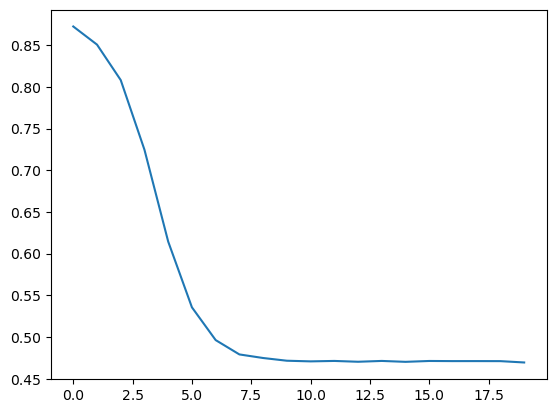

In [138]:
import matplotlib.pyplot as plt 

autoencoder = AutoEncoder() 
errs = [] 
for _ in range(20): 
    errs.append(autoencoder.fit(memorize=True)) 
    pass 

plt.plot(errs) 
plt.show()

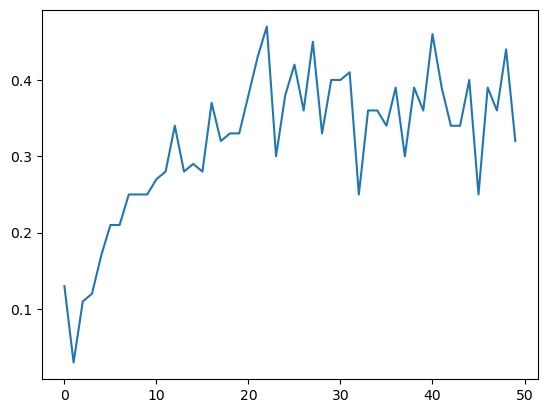

In [189]:
sub_sample = sample(20, sub_sample=True) 

classifier_without_transfer = Classifier() 
accs = [] 
for _ in range(50): 
    accs.append(classifier_without_transfer.fit(batch_size=len(sub_sample), train_data=sub_sample)) 
    pass 

plt.plot(accs) 
plt.show()

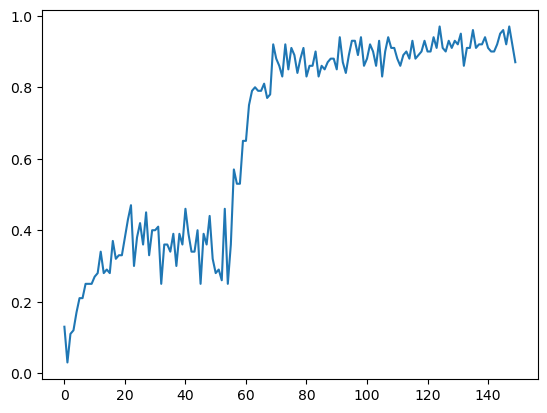

In [190]:
base_classifier = Classifier() 
for _ in range(50): 
    ## burn-in 
    accs.append(base_classifier.fit())
    pass 
for _ in range(50): 
    ## consolidate 
    accs.append(base_classifier.fit(memorize=True))
    pass 

plt.plot(accs) 
plt.show() 

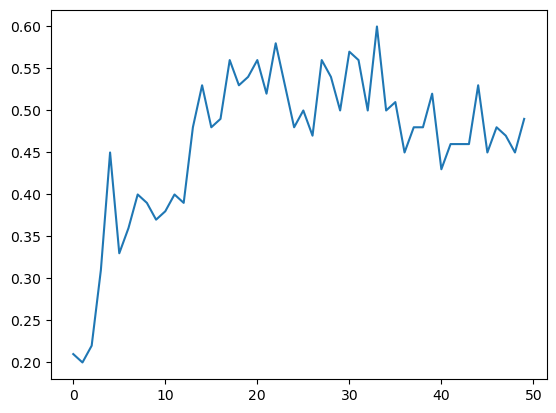

In [192]:
classifier_with_transfer = Classifier(base_layer_transfer=base_classifier.base_layer) 

accs = [] 
for _ in range(50): 
    accs.append(classifier_with_transfer.fit(batch_size=len(sub_sample), train_data=sub_sample, use_memory=True)) 
    pass 

plt.plot(accs) 
plt.show() 

## Interpretation: the primed parameters obviously generate lift, as they should. 
## I further expect that the lift will degrade as the abstraction degrades, 
## for example drifting to a mixed task of autoencoding from classification. 
## The better question is whether this is better for out-of-sample learning;. 

In [ ]:
classifier_with_transfer = Classifier(base_layer_transfer=autoencoder.base_layer) 
accs = [] 
for _ in range(100): 
    accs.append(classifier_with_transfer.fit(train_data=sub_sample)) 
    pass 

plt.plot(accs) 
plt.show() 

## interpretation: autoencoders produce bad abstractions 